## Importing the Required Libraries

In [ ]:
import os
import random
from time import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Setup and Reproducibility

In [ ]:
# Use single-precision floats and complex numbers
TF_DTYPE = 'float32'
TF_CTYPE = 'complex64'
tf.keras.backend.set_floatx(TF_DTYPE)

# Set seeds for reproducibility
seed_val = 0
random.seed(seed_val)
np.random.seed(seed_val)
tf.random.set_seed(seed_val)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.threading.set_inter_op_parallelism_threads(1)

## Define the Test Problem and Analytic Solutions

In [ ]:
# Define temporal and spatial boundaries
t_init  = tf.constant(0.0, dtype=TF_DTYPE)   # initial time
t_end   = tf.constant(np.pi, dtype=TF_DTYPE)   # final time
x_left  = tf.constant(0.0, dtype=TF_DTYPE)       # spatial left boundary
x_right = tf.constant(1.0, dtype=TF_DTYPE)       # spatial right boundary

# Physical constants (set to unity for simplicity)
h_bar  = tf.constant(1.0, dtype=TF_DTYPE)
mass   = tf.constant(1.0, dtype=TF_DTYPE)
c_hbar = tf.cast(h_bar, TF_CTYPE)
c_mass = tf.cast(mass, TF_CTYPE)

# Define a plane wave analytic solution for the Schrödinger equation:
def plane_wave(x, t):
    # Define wave number and frequency based on dispersion relation for free particles
    k     = 1.0
    omega = 0.5 / mass * k**2
    re = tf.cos(k*x - omega*t)
    im = tf.sin(k*x - omega*t)
    return tf.concat([re, im], axis=1)

# Main analytic solution; it is currently assigned to the plane wave solution.
def psi_exact(x, t):
    return plane_wave(x, t)

# Extract density, real and imaginary parts from the complex output representation
def get_density(psi):
    return tf.square(psi[:, 0]) + tf.square(psi[:, 1])
def get_real(psi):
    return psi[:, 0]
def get_imag(psi):
    return psi[:, 1]


## Generate Training and Validation Data

In [ ]:
# Set numbers of points
num_initial     = 50
num_boundary    = 50
num_collocation = 10000

# --- Initial condition data ---
t_initial  = tf.ones((num_initial, 1), dtype=TF_DTYPE) * t_init
x_initial  = tf.random.uniform((num_initial, 1), x_left, x_right, dtype=TF_DTYPE)
xt_initial = tf.concat([x_initial, t_initial], axis=1)
psi_initial = psi_exact(x_initial, t_initial)

# --- Boundary condition data ---
t_boundary = tf.random.uniform((num_boundary, 1), t_init, t_end, dtype=TF_DTYPE)
# Randomly assign left (x_left) or right (x_right) boundary
x_boundary = x_left + (x_right - x_left) * tf.keras.backend.random_bernoulli((num_boundary,1), 0.5, dtype=TF_DTYPE)
xt_boundary = tf.concat([x_boundary, t_boundary], axis=1)
psi_boundary = psi_exact(x_boundary, t_boundary)

# --- Collocation points for enforcing the PDE ---
t_collocation = tf.random.uniform((num_collocation, 1), t_init, t_end, dtype=TF_DTYPE)
x_collocation = tf.random.uniform((num_collocation, 1), x_left, x_right, dtype=TF_DTYPE)
xt_collocation = tf.concat([x_collocation, t_collocation], axis=1)

## Visualize the Input Data (Initial and Boundary Conditions)

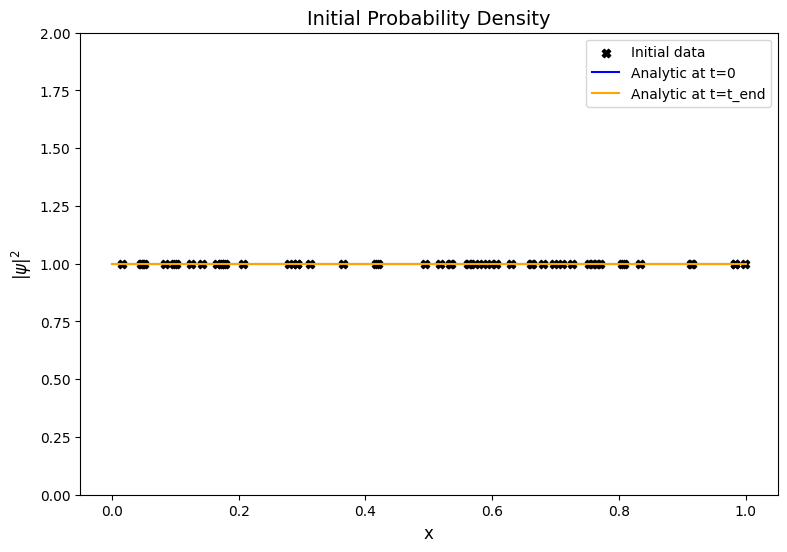

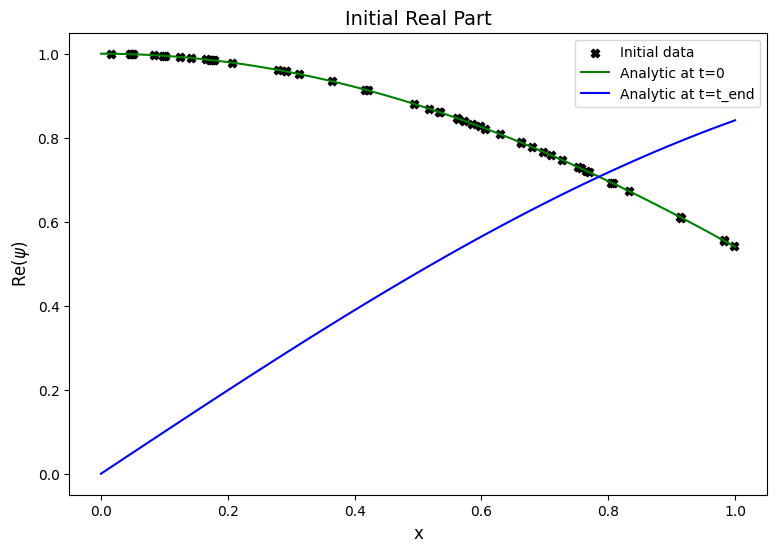

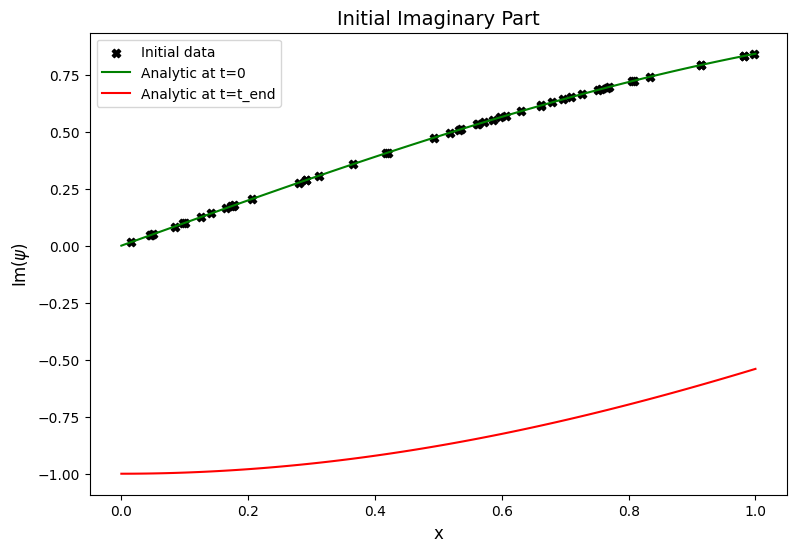

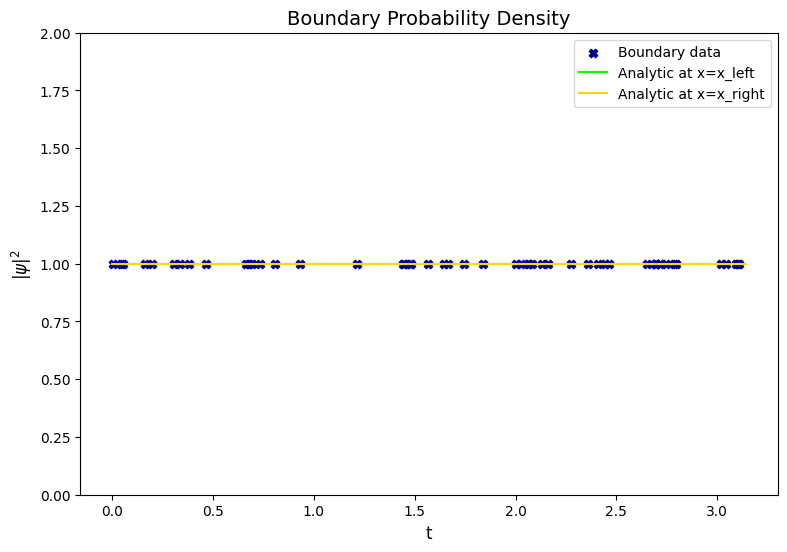

In [ ]:
n_samples_lin = 100
x_lin   = tf.reshape(tf.linspace(x_left, x_right, n_samples_lin), (n_samples_lin, 1))
t0_lin  = tf.ones((n_samples_lin, 1), dtype=TF_DTYPE) * t_init
t1_lin  = tf.ones((n_samples_lin, 1), dtype=TF_DTYPE) * t_end

psi0_lin = psi_exact(x_lin, t0_lin)
psi1_lin = psi_exact(x_lin, t1_lin)
psi_left_lin = psi_exact(tf.ones((n_samples_lin, 1), dtype=TF_DTYPE)*x_left, tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1)))
psi_right_lin = psi_exact(tf.ones((n_samples_lin, 1), dtype=TF_DTYPE)*x_right, tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1)))

# Plot density for initial conditions
plt.figure(figsize=(9,6))
plt.title('Initial Probability Density', fontsize=14)
plt.scatter(x_initial, get_density(psi_initial), marker='X', color='black', label="Initial data")
plt.plot(x_lin, get_density(psi0_lin), color='blue', label="Analytic at t=0")
plt.plot(x_lin, get_density(psi1_lin), color='orange', label="Analytic at t=t_end")
plt.ylim(0, 2)
plt.xlabel('x', fontsize=12)
plt.ylabel(r'$|\psi|^2$', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()

# Plot real and imaginary parts at t=0
plt.figure(figsize=(9,6))
plt.title('Initial Real Part', fontsize=14)
plt.scatter(x_initial, get_real(psi_initial), marker='X', color='black', label="Initial data")
plt.plot(x_lin, get_real(psi0_lin), color='green', label="Analytic at t=0")
plt.plot(x_lin, get_real(psi1_lin), color='blue', label="Analytic at t=t_end")
plt.xlabel('x', fontsize=12)
plt.ylabel(r'Re($\psi$)', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()

plt.figure(figsize=(9,6))
plt.title('Initial Imaginary Part', fontsize=14)
plt.scatter(x_initial, get_imag(psi_initial), marker='X', color='black', label="Initial data")
plt.plot(x_lin, get_imag(psi0_lin), color='green', label="Analytic at t=0")
plt.plot(x_lin, get_imag(psi1_lin), color='red', label="Analytic at t=t_end")
plt.xlabel('x', fontsize=12)
plt.ylabel(r'Im($\psi$)', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()

# Plot boundary conditions (as a function of time)
plt.figure(figsize=(9,6))
plt.title('Boundary Probability Density', fontsize=14)
plt.scatter(t_boundary, get_density(psi_boundary), marker='X', color='darkblue', label="Boundary data")
plt.plot(tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1)), get_density(psi_left_lin), color='lime', label="Analytic at x=x_left")
plt.plot(tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1)), get_density(psi_right_lin), color='gold', label="Analytic at x=x_right")
plt.ylim(0, 2)
plt.xlabel('t', fontsize=12)
plt.ylabel(r'$|\psi|^2$', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()

## Neural Network Model Setup (PINN)

In [ ]:
# Define lower and upper bounds for scaling
lb = tf.stack([x_left, t_init], axis=0)
ub = tf.stack([x_right, t_end], axis=0)

def create_model(num_layers=4, neurons_per_layer=20):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(2,)))  # (x, t)
    # Normalize inputs to [-1, 1]
    model.add(tf.keras.layers.Lambda(lambda z: 2.0 * (z - lb)/(ub - lb) - 1.0))
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(neurons_per_layer,
                                        activation='tanh',
                                        kernel_initializer='glorot_normal'))
    # Two outputs: real and imaginary parts
    model.add(tf.keras.layers.Dense(2))
    return model

# Test the model interface
pinn_model = create_model()
_ = pinn_model(xt_collocation)

## Define Residual and Loss Computations

In [ ]:
def compute_pde_residual(model, xt):
    with tf.GradientTape(persistent=True) as tape:
        x = xt[:, 0:1]
        t = xt[:, 1:2]
        tape.watch(x)
        tape.watch(t)
        psi_val = model(tf.concat([x, t], axis=1))
        re = psi_val[:, 0]
        im = psi_val[:, 1]
        re_x = tape.gradient(re, x)
        im_x = tape.gradient(im, x)
    re_t = tape.gradient(re, t)
    im_t = tape.gradient(im, t)
    re_xx = tape.gradient(re_x, x)
    im_xx = tape.gradient(im_x, x)
    del tape
    # Residual formulation; note that potential is zero here.
    # These are rearranged for convenience.
    res_re = re_t + 0.5 * im_xx
    res_im = im_t - 0.5 * re_xx
    return tf.concat([res_re, res_im], axis=1)

def compute_loss_components(model, xt_colloc, xt_init, psi_init, xt_bdry, psi_bdry):
    loss_pde    = tf.reduce_mean(tf.square(compute_pde_residual(model, xt_colloc)))
    loss_init   = tf.reduce_mean(tf.square(model(xt_init) - psi_init))
    loss_bdry   = tf.reduce_mean(tf.square(model(xt_bdry) - psi_bdry))
    return loss_pde, loss_init, loss_bdry

def total_loss(model, xt_colloc, xt_init, psi_init, xt_bdry, psi_bdry):
    loss_pde, loss_init, loss_bdry = compute_loss_components(model, xt_colloc, xt_init, psi_init, xt_bdry, psi_bdry)
    return loss_pde + loss_init + loss_bdry

def compute_gradients(model, xt_colloc, xt_init, psi_init, xt_bdry, psi_bdry):
    with tf.GradientTape() as tape:
        loss_val = total_loss(model, xt_colloc, xt_init, psi_init, xt_bdry, psi_bdry)
    grads = tape.gradient(loss_val, model.trainable_variables)
    return loss_val, grads

## Training Setup with Custom Learning Rate Schedule

In [ ]:
# Setup learning rate schedule: piecewise constant decay
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000], [1e-2, 1e-3, 5e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

def train_step(model):
    loss_val, grads = compute_gradients(model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_val


## Training Loop (with additional logging for analysis)

In [ ]:
epochs = 5000
loss_history = []
loss_pde_history = []
loss_init_history = []
loss_bdry_history = []
error_L1_history = []
error_L2_history = []

t_start = time()
for epoch in range(epochs + 1):
    current_loss = train_step(pinn_model)
    loss_history.append(current_loss.numpy())
    lpde, linit, lbdry = compute_loss_components(pinn_model, xt_collocation, xt_initial, psi_initial, xt_boundary, psi_boundary)
    loss_pde_history.append(lpde.numpy())
    loss_init_history.append(linit.numpy())
    loss_bdry_history.append(lbdry.numpy())

    # Every 100 epochs, compute error norms on an independent test set
    if epoch % 100 == 0:
        n_test = 10000
        t_test  = tf.random.uniform((n_test, 1), t_init, t_end, dtype=TF_DTYPE)
        x_test  = tf.random.uniform((n_test, 1), x_left, x_right, dtype=TF_DTYPE)
        xt_test = tf.concat([x_test, t_test], axis=1)
        psi_test_exact = psi_exact(x_test, t_test)
        psi_test_pred  = pinn_model(xt_test)
        error_abs = tf.abs(psi_test_exact - psi_test_pred)
        error_L1_history.append(tf.reduce_mean(error_abs).numpy())
        error_L2_history.append(tf.sqrt(tf.reduce_mean(tf.square(psi_test_exact - psi_test_pred))).numpy())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:05d}: Total loss = {current_loss.numpy():.8e}, "
              f"PDE loss = {lpde.numpy():.8e}, "
              f"Initial loss = {linit.numpy():.8e}, "
              f"Boundary loss = {lbdry.numpy():.8e}")

print(f"\nTraining Time: {time() - t_start:.2f} seconds")

Epoch 00000: Total loss = 1.17968512e+00, PDE loss = 4.58579101e-02, Initial loss = 9.28064808e-02, Boundary loss = 2.90665805e-01
Epoch 00050: Total loss = 1.75138358e-02, PDE loss = 8.57544132e-03, Initial loss = 2.00267788e-03, Boundary loss = 6.56150002e-03
Epoch 00100: Total loss = 2.59007630e-03, PDE loss = 1.30348839e-03, Initial loss = 2.87820061e-04, Boundary loss = 9.23233980e-04
Epoch 00150: Total loss = 1.02072163e-03, PDE loss = 4.89900704e-04, Initial loss = 1.04964638e-04, Boundary loss = 4.12684196e-04
Epoch 00200: Total loss = 5.79481479e-04, PDE loss = 2.16203407e-04, Initial loss = 6.16319230e-05, Boundary loss = 2.95868580e-04
Epoch 00250: Total loss = 3.67345347e-04, PDE loss = 1.20858916e-04, Initial loss = 4.00224562e-05, Boundary loss = 2.03506104e-04
Epoch 00300: Total loss = 2.58917862e-04, PDE loss = 8.79857616e-05, Initial loss = 2.80329205e-05, Boundary loss = 1.41341239e-04
Epoch 00350: Total loss = 1.96893670e-04, PDE loss = 7.18075607e-05, Initial loss =

## Visualize the Trained Model Data (Initial and Boundary Conditions)

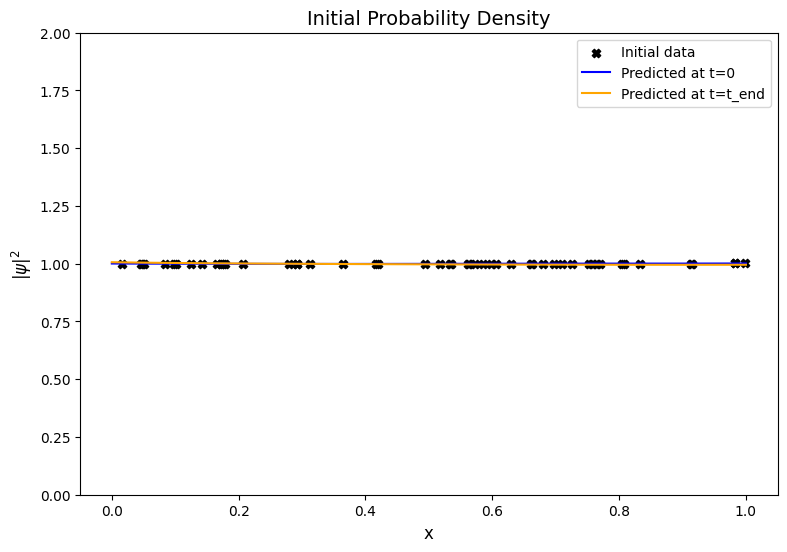

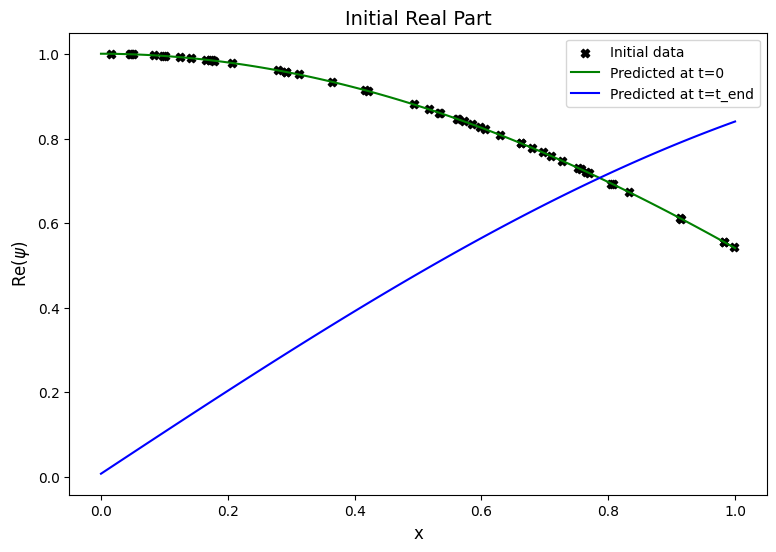

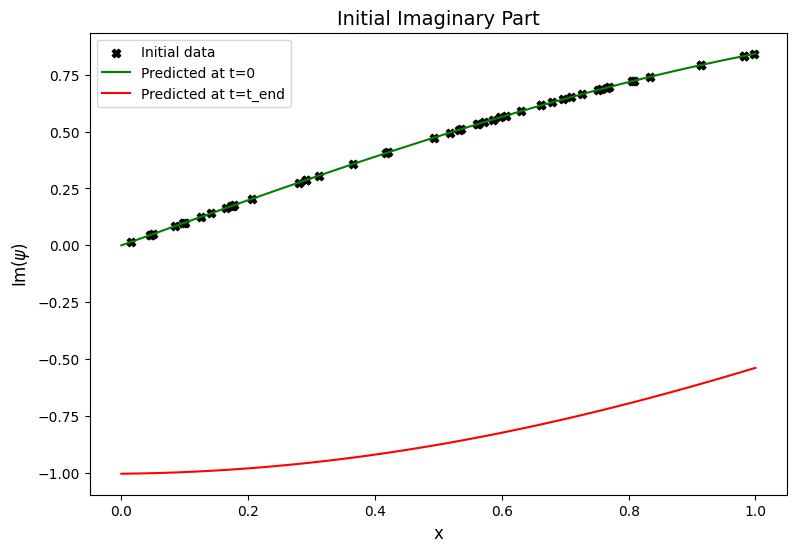

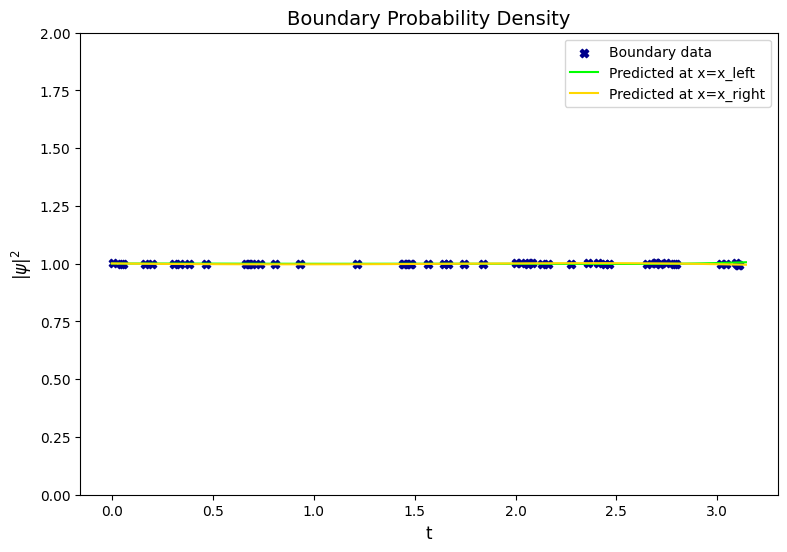

In [ ]:
n_samples_lin = 100
x_lin   = tf.reshape(tf.linspace(x_left, x_right, n_samples_lin), (n_samples_lin, 1))
t0_lin  = tf.ones((n_samples_lin, 1), dtype=TF_DTYPE) * t_init
t1_lin  = tf.ones((n_samples_lin, 1), dtype=TF_DTYPE) * t_end

# Evaluate the trained model on a uniform grid
psi0_lin_pred = pinn_model(tf.concat([x_lin, t0_lin], axis=1))
psi1_lin_pred = pinn_model(tf.concat([x_lin, t1_lin], axis=1))
psi_left_lin_pred = pinn_model(tf.concat([tf.ones((n_samples_lin, 1), dtype=TF_DTYPE) * x_left,
                                           tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1))], axis=1))
psi_right_lin_pred = pinn_model(tf.concat([tf.ones((n_samples_lin, 1), dtype=TF_DTYPE) * x_right,
                                            tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1))], axis=1))

# Also compute the predictions on the training initial and boundary data:
psi_initial_pred = pinn_model(xt_initial)    # predictions at t=t_init for training points
psi_boundary_pred = pinn_model(xt_boundary)    # predictions at boundaries

# ---------------------------------------------------------------------------
# Plot density for initial conditions (using trained model predictions)
plt.figure(figsize=(9,6))
plt.title('Initial Probability Density', fontsize=14)
plt.scatter(x_initial, get_density(psi_initial_pred), marker='X', color='black', label="Initial data")
plt.plot(x_lin, get_density(psi0_lin_pred), color='blue', label="Predicted at t=0")
plt.plot(x_lin, get_density(psi1_lin_pred), color='orange', label="Predicted at t=t_end")
plt.ylim(0, 2)
plt.xlabel('x', fontsize=12)
plt.ylabel(r'$|\psi|^2$', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()

# ---------------------------------------------------------------------------
# Plot real and imaginary parts at t=0 for the trained model
plt.figure(figsize=(9,6))
plt.title('Initial Real Part', fontsize=14)
plt.scatter(x_initial, get_real(psi_initial_pred), marker='X', color='black', label="Initial data")
plt.plot(x_lin, get_real(psi0_lin_pred), color='green', label="Predicted at t=0")
plt.plot(x_lin, get_real(psi1_lin_pred), color='blue', label="Predicted at t=t_end")
plt.xlabel('x', fontsize=12)
plt.ylabel(r'Re($\psi$)', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()

plt.figure(figsize=(9,6))
plt.title('Initial Imaginary Part', fontsize=14)
plt.scatter(x_initial, get_imag(psi_initial_pred), marker='X', color='black', label="Initial data")
plt.plot(x_lin, get_imag(psi0_lin_pred), color='green', label="Predicted at t=0")
plt.plot(x_lin, get_imag(psi1_lin_pred), color='red', label="Predicted at t=t_end")
plt.xlabel('x', fontsize=12)
plt.ylabel(r'Im($\psi$)', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()

# ---------------------------------------------------------------------------
# Plot boundary conditions (as a function of time) for the trained model
plt.figure(figsize=(9,6))
plt.title('Boundary Probability Density', fontsize=14)
plt.scatter(t_boundary, get_density(psi_boundary_pred), marker='X', color='darkblue', label="Boundary data")
plt.plot(tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1)), get_density(psi_left_lin_pred), color='lime', label="Predicted at x=x_left")
plt.plot(tf.reshape(tf.linspace(t_init, t_end, n_samples_lin), (n_samples_lin, 1)), get_density(psi_right_lin_pred), color='gold', label="Predicted at x=x_right")
plt.ylim(0, 2)
plt.xlabel('t', fontsize=12)
plt.ylabel(r'$|\psi|^2$', fontsize=12)
plt.legend(fontsize=10)
plt.show()
plt.close()


## Model Performance Analysis

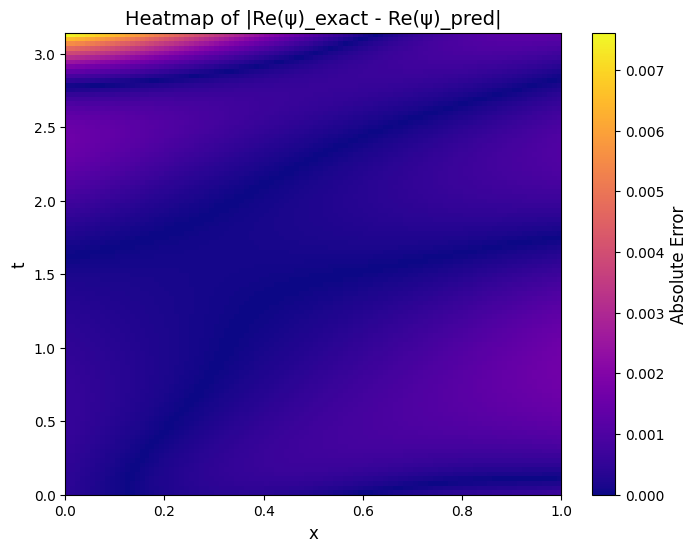

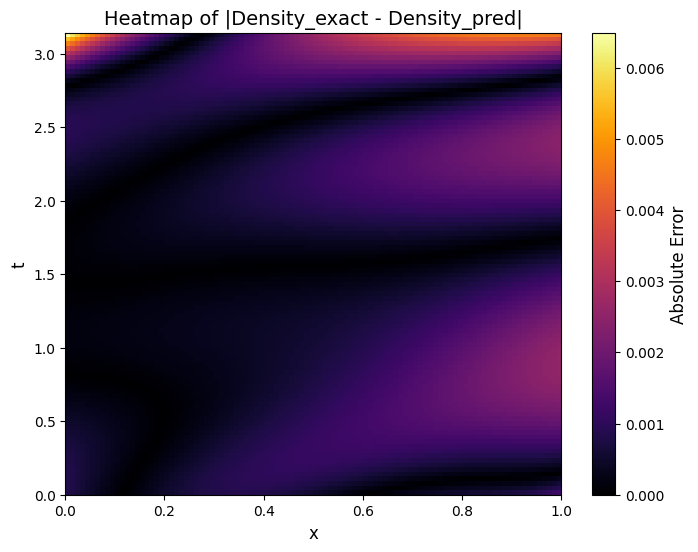

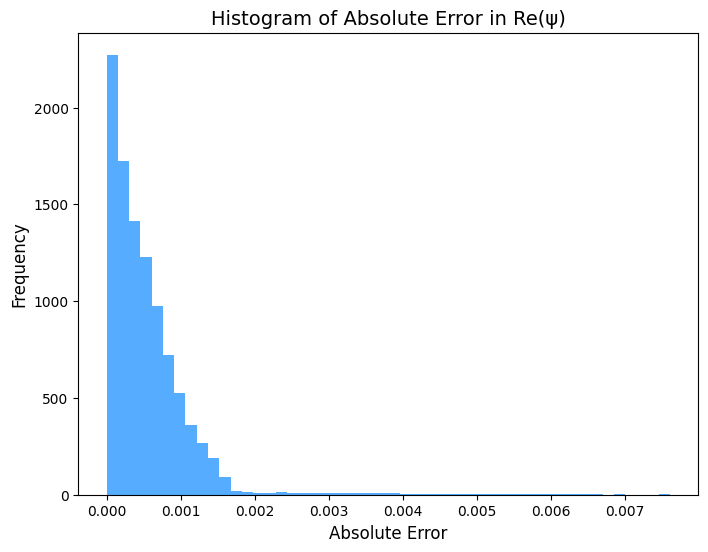

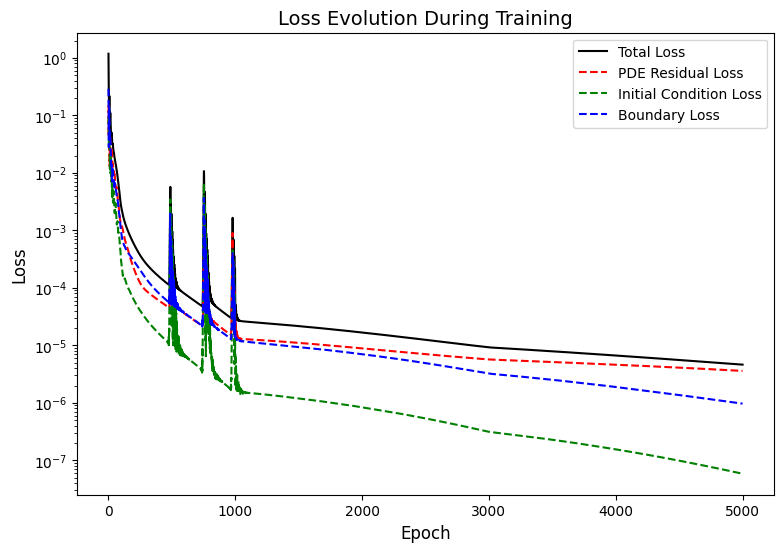

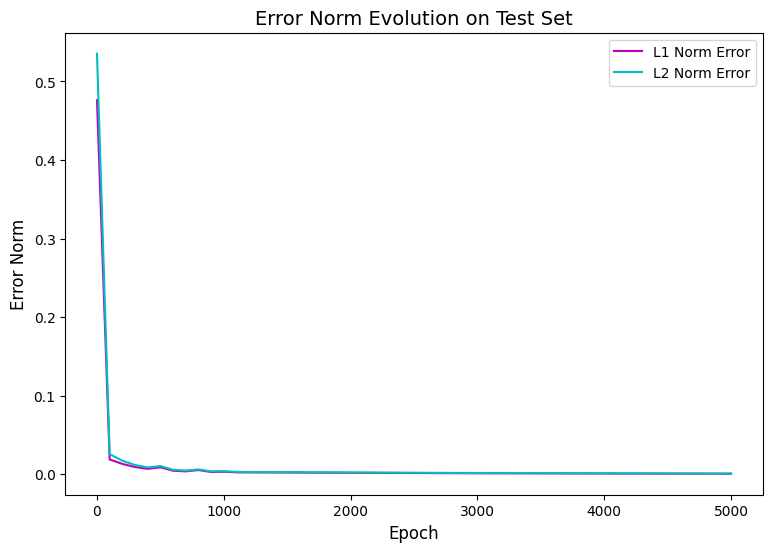

In [ ]:
# Evaluate on collocation points and create a dense grid for error maps
psi_colloc_pred = pinn_model(xt_collocation)
n_grid = 100
x_grid = np.linspace(x_left.numpy(), x_right.numpy(), n_grid)
t_grid = np.linspace(t_init.numpy(), t_end.numpy(), n_grid)
xx, tt = np.meshgrid(x_grid, t_grid)
xt_grid = tf.constant(np.vstack([xx.flatten(), tt.flatten()]).T, dtype=TF_DTYPE)

psi_grid_exact = psi_exact(xt_grid[:,0:1], xt_grid[:,1:2]).numpy()
psi_grid_pred  = pinn_model(xt_grid).numpy()

re_exact = psi_grid_exact[:, 0].reshape(n_grid, n_grid)
re_pred  = psi_grid_pred[:, 0].reshape(n_grid, n_grid)
density_exact = (np.square(psi_grid_exact[:,0]) + np.square(psi_grid_exact[:,1])).reshape(n_grid, n_grid)
density_pred  = (np.square(psi_grid_pred[:,0]) + np.square(psi_grid_pred[:,1])).reshape(n_grid, n_grid)

# ----- Plot 1: Heatmap of the pointwise error (Real Part) -----
error_re = np.abs(re_exact - re_pred)
plt.figure(figsize=(8,6))
plt.title('Heatmap of |Re(ψ)_exact - Re(ψ)_pred|', fontsize=14)
plt.imshow(error_re, extent=[x_left.numpy(), x_right.numpy(), t_init.numpy(), t_end.numpy()], origin='lower', cmap='plasma', aspect='auto')
plt.xlabel('x', fontsize=12)
plt.ylabel('t', fontsize=12)
cbar = plt.colorbar()
cbar.set_label('Absolute Error', fontsize=12)
plt.show()
plt.close()

# ----- Plot 2: Heatmap of the pointwise error (Density) -----
error_density = np.abs(density_exact - density_pred)
plt.figure(figsize=(8,6))
plt.title('Heatmap of |Density_exact - Density_pred|', fontsize=14)
plt.imshow(error_density, extent=[x_left.numpy(), x_right.numpy(), t_init.numpy(), t_end.numpy()], origin='lower', cmap='inferno', aspect='auto')
plt.xlabel('x', fontsize=12)
plt.ylabel('t', fontsize=12)
cbar = plt.colorbar()
cbar.set_label('Absolute Error', fontsize=12)
plt.show()
plt.close()

# ----- Plot 3: Histogram of the Absolute Errors (Real Part) -----
plt.figure(figsize=(8,6))
plt.title('Histogram of Absolute Error in Re(ψ)', fontsize=14)
plt.hist(error_re.flatten(), bins=50, color='dodgerblue', alpha=0.75)
plt.xlabel('Absolute Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
plt.close()

# ----- Plot 4: Loss Evolution (Total and Components) -----
plt.figure(figsize=(9,6))
plt.semilogy(loss_history, 'k-', label='Total Loss')
plt.semilogy(loss_pde_history, 'r--', label='PDE Residual Loss')
plt.semilogy(loss_init_history, 'g--', label='Initial Condition Loss')
plt.semilogy(loss_bdry_history, 'b--', label='Boundary Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Loss Evolution During Training', fontsize=14)
plt.show()
plt.close()

# ----- Plot 5: Error Norms vs. Epochs -----
plt.figure(figsize=(9,6))
epochs_recorded = np.arange(0, epochs+1, 100)
plt.plot(epochs_recorded, error_L1_history, 'm-', label='L1 Norm Error')
plt.plot(epochs_recorded, error_L2_history, 'c-', label='L2 Norm Error')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Error Norm', fontsize=12)
plt.legend(fontsize=10)
plt.title('Error Norm Evolution on Test Set', fontsize=14)
plt.show()
plt.close()

## Physical Properties Analysis

<ipython-input-24-c8163aab4c34>:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm_val = np.trapz(density_vals, x_vals)


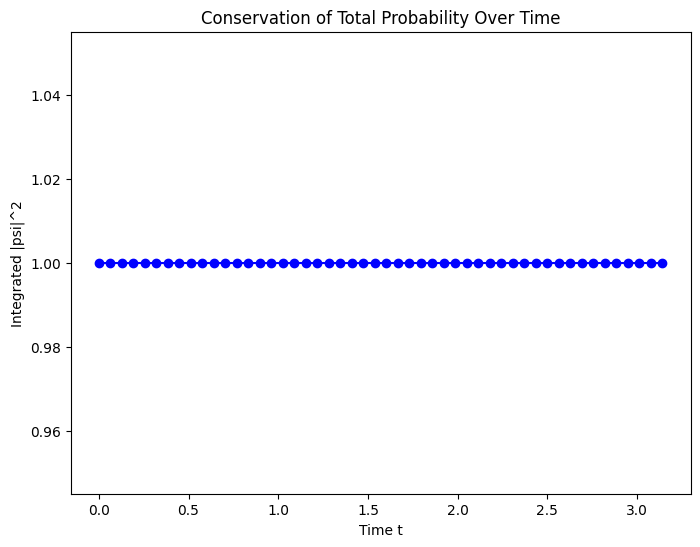

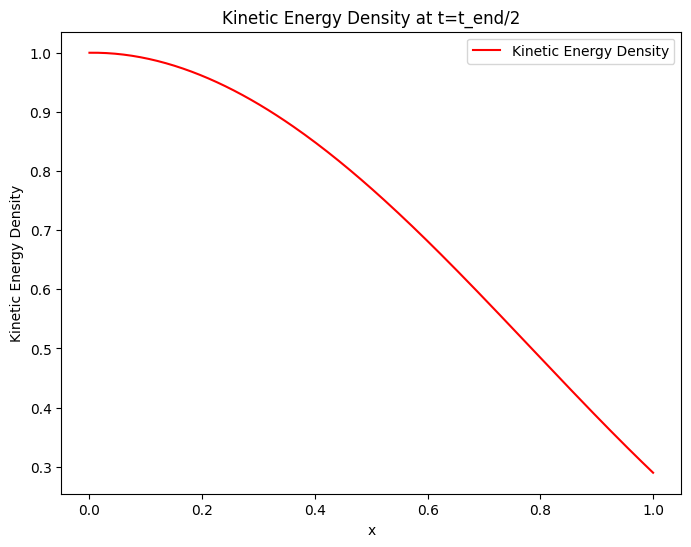

In [ ]:
# Check the probability normalization over time:
# For a conserved quantum probability, the integral of |psi|^2 over x should be constant.
prob_norm = []
t_snapshots = np.linspace(t_init.numpy(), t_end.numpy(), 50)
for t_val in t_snapshots:
    x_vals = np.linspace(x_left.numpy(), x_right.numpy(), 200)
    t_vals = np.full_like(x_vals, t_val)
    psi_vals = psi_exact(tf.constant(x_vals.reshape(-1, 1), dtype=TF_DTYPE),
                          tf.constant(t_vals.reshape(-1, 1), dtype=TF_DTYPE))
    density_vals = get_density(psi_vals).numpy().flatten()
    # Using simple trapezoidal integration over x
    norm_val = np.trapz(density_vals, x_vals)
    prob_norm.append(norm_val)

plt.figure(figsize=(8,6))
plt.plot(t_snapshots, prob_norm, 'bo-')
plt.xlabel('Time t')
plt.ylabel('Integrated |psi|^2')
plt.title('Conservation of Total Probability Over Time')
plt.show()
plt.close()

# Compute and plot Kinetic Energy Density at a given time snapshot.
# Using the approximation T(x,t) ~ 0.5 * |grad psi|^2.
def kinetic_energy_density(model, x, t):
    with tf.GradientTape() as tape:
        tape.watch(x)
        psi_val = model(tf.concat([x, t], axis=1))
    grad_psi = tape.gradient(psi_val, x)
    # Sum of squares over the two components (real and imaginary) approximates |∇psi|^2.
    return 0.5 * tf.reduce_sum(tf.square(grad_psi), axis=1)

# Choose a snapshot time (e.g., t = t_end/2)
t_snapshot = tf.ones((200, 1), dtype=TF_DTYPE) * (t_end/2)
x_vals = tf.constant(np.linspace(x_left.numpy(), x_right.numpy(), 200).reshape(-1, 1), dtype=TF_DTYPE)
T_density = kinetic_energy_density(pinn_model, x_vals, t_snapshot)

plt.figure(figsize=(8,6))
plt.plot(x_vals.numpy(), T_density.numpy(), 'r-', label='Kinetic Energy Density')
plt.xlabel('x')
plt.ylabel('Kinetic Energy Density')
plt.title('Kinetic Energy Density at t=t_end/2')
plt.legend()
plt.show()
plt.close()

## 3D Visualization of the Predicted Real Part

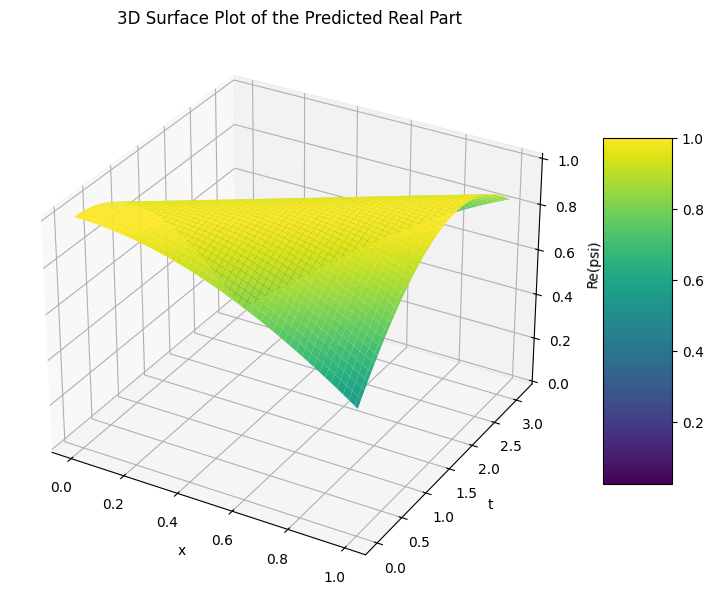

In [ ]:
psi_pred_grid = pinn_model(xt_grid).numpy()
re_pred_grid = psi_pred_grid[:,0].reshape(n_grid, n_grid)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xx, tt, re_pred_grid, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Re(psi)')
ax.set_title('3D Surface Plot of the Predicted Real Part')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
plt.close()